In [1]:
from doctr.models import ocr_predictor
from doctr.io import DocumentFile
from doctr.io import read_img_as_numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from typing import Any, Dict, List, Optional, Tuple, Union


In [6]:
model = ocr_predictor(pretrained=True, assume_straight_pages=True)
# single_img_doc = DocumentFile.from_images("SAMPLE_IMAGES_CybergyHoldings_AffiliateAgreement/pg2.jpg")
full_pdf = DocumentFile.from_pdf("SAMPLE_LinkPlusCorp.pdf")

In [7]:
result = model(full_pdf)

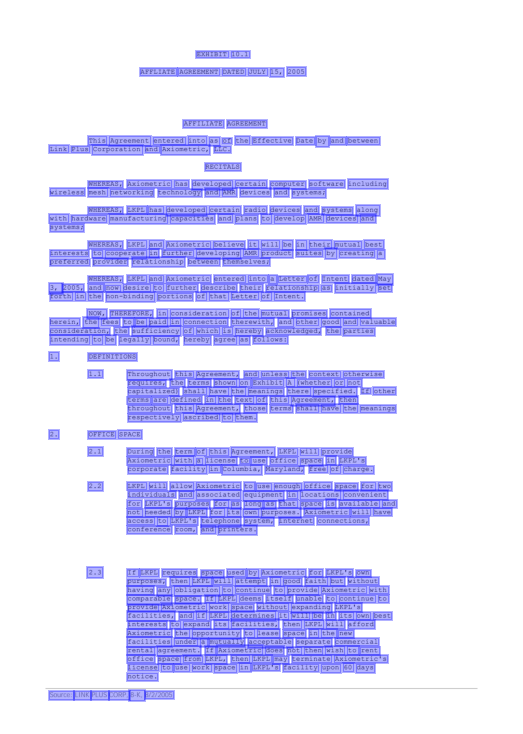

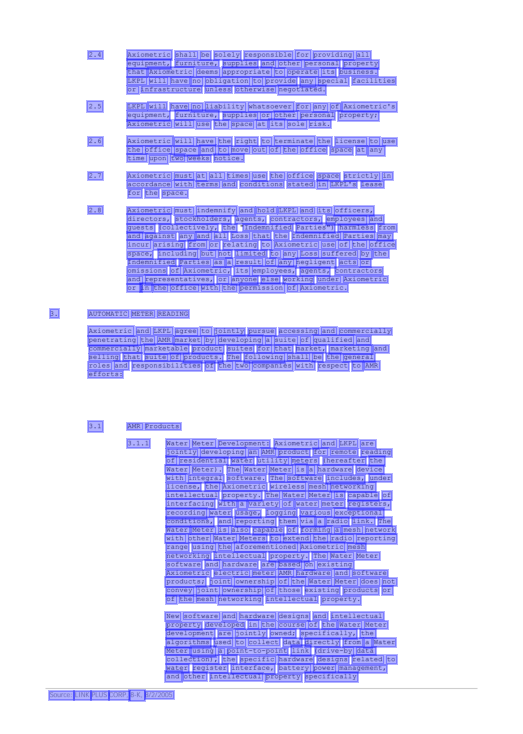

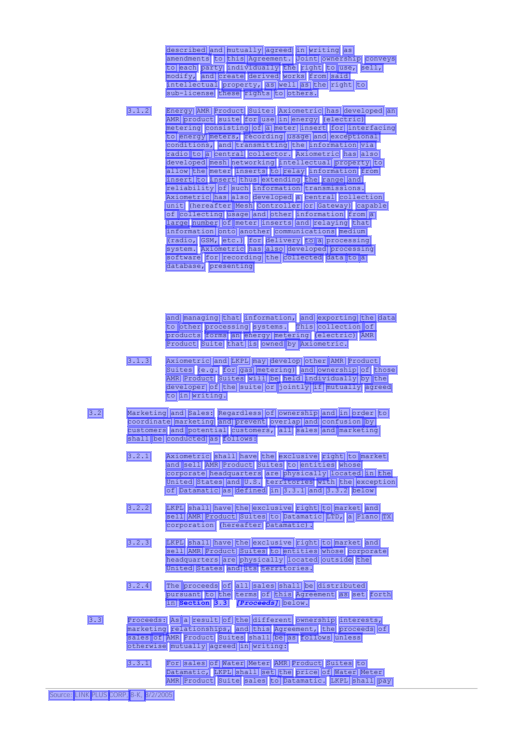

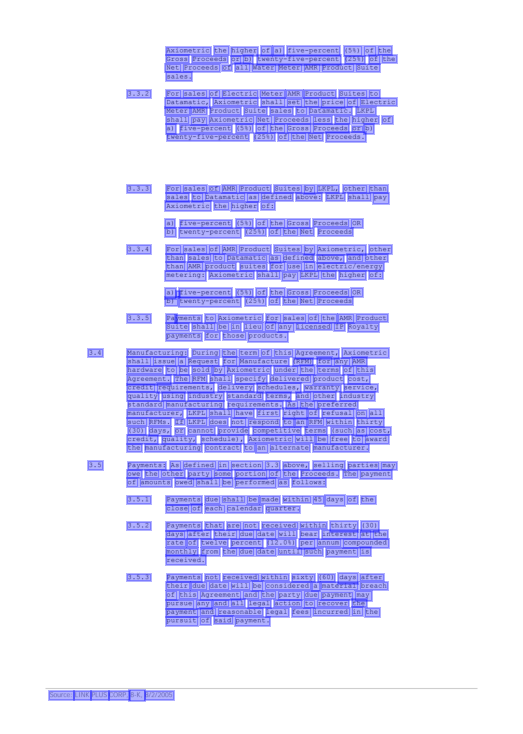

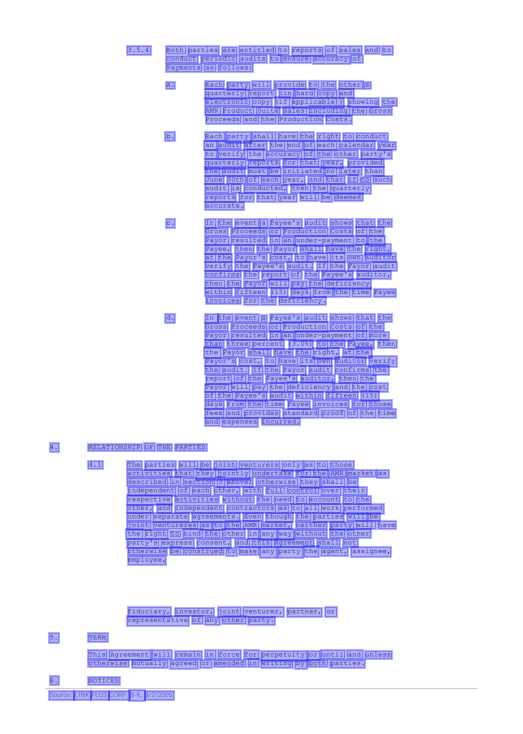

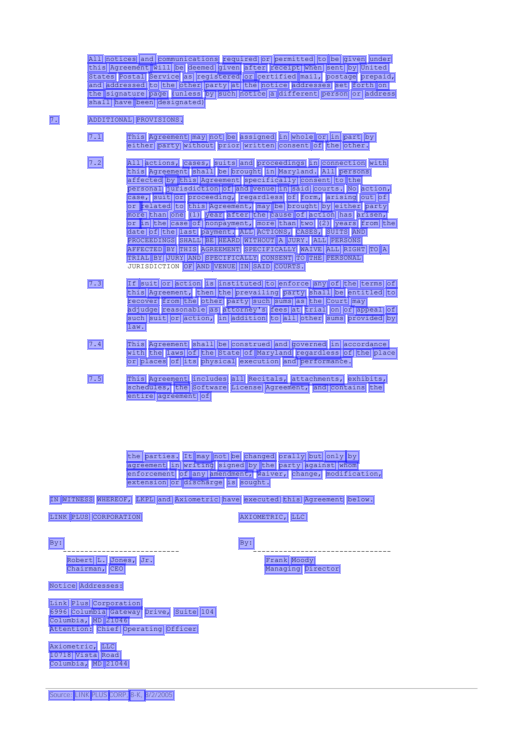

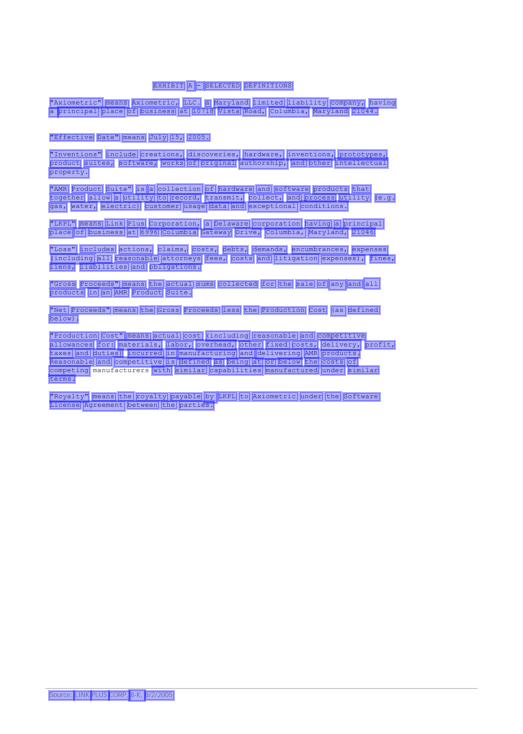

In [8]:
result.show(full_pdf)

In [37]:
# Modified code from doctr github
Point2D = Tuple[float, float]
BoundingBox = Tuple[Point2D, Point2D]
Polygon4P = Tuple[Point2D, Point2D, Point2D, Point2D]

def rect_patch(
    geometry: BoundingBox,
    page_dimensions: Tuple[int, int],
    label: Optional[str] = None,
    color: Tuple[float, float, float] = (0, 0, 0),
    alpha: float = 0.3,
    linewidth: int = 2,
    fill: bool = True,
    preserve_aspect_ratio: bool = False
) -> patches.Rectangle:
    """Create a matplotlib rectangular patch for the element

    Args:
        geometry: bounding box of the element
        page_dimensions: dimensions of the Page in format (height, width)
        label: label to display when hovered
        color: color to draw box
        alpha: opacity parameter to fill the boxes, 0 = transparent
        linewidth: line width
        fill: whether the patch should be filled
        preserve_aspect_ratio: pass True if you passed True to the predictor

    Returns:
        a rectangular Patch
    """

    if len(geometry) != 2 or any(not isinstance(elt, tuple) or len(elt) != 2 for elt in geometry):
        raise ValueError("invalid geometry format")

    # Unpack
    height, width = page_dimensions
    (xmin, ymin), (xmax, ymax) = geometry
    # Switch to absolute coords
    if preserve_aspect_ratio:
        width = height = max(height, width)
    xmin, w = xmin * width, (xmax - xmin) * width
    ymin, h = ymin * height, (ymax - ymin) * height

    return patches.Rectangle(
        (xmin, ymin),
        w,
        h,
        fill=fill,
        linewidth=linewidth,
        edgecolor=(*color, alpha),
        facecolor=(*color, alpha),
        label=label,
    )



def create_obj_patch(
    geometry: Union[BoundingBox, Polygon4P, np.ndarray],
    page_dimensions: Tuple[int, int],
    **kwargs: Any,
) -> patches.Patch:
    """Create a matplotlib patch for the element

    Args:
        geometry: bounding box (straight or rotated) of the element
        page_dimensions: dimensions of the page in format (height, width)

    Returns:
        a matplotlib Patch
    """
    if isinstance(geometry, tuple):
        if len(geometry) == 2:  # straight word BB (2 pts)
            return rect_patch(geometry, page_dimensions, **kwargs)  # type: ignore[arg-type]
    raise ValueError("invalid geometry format")

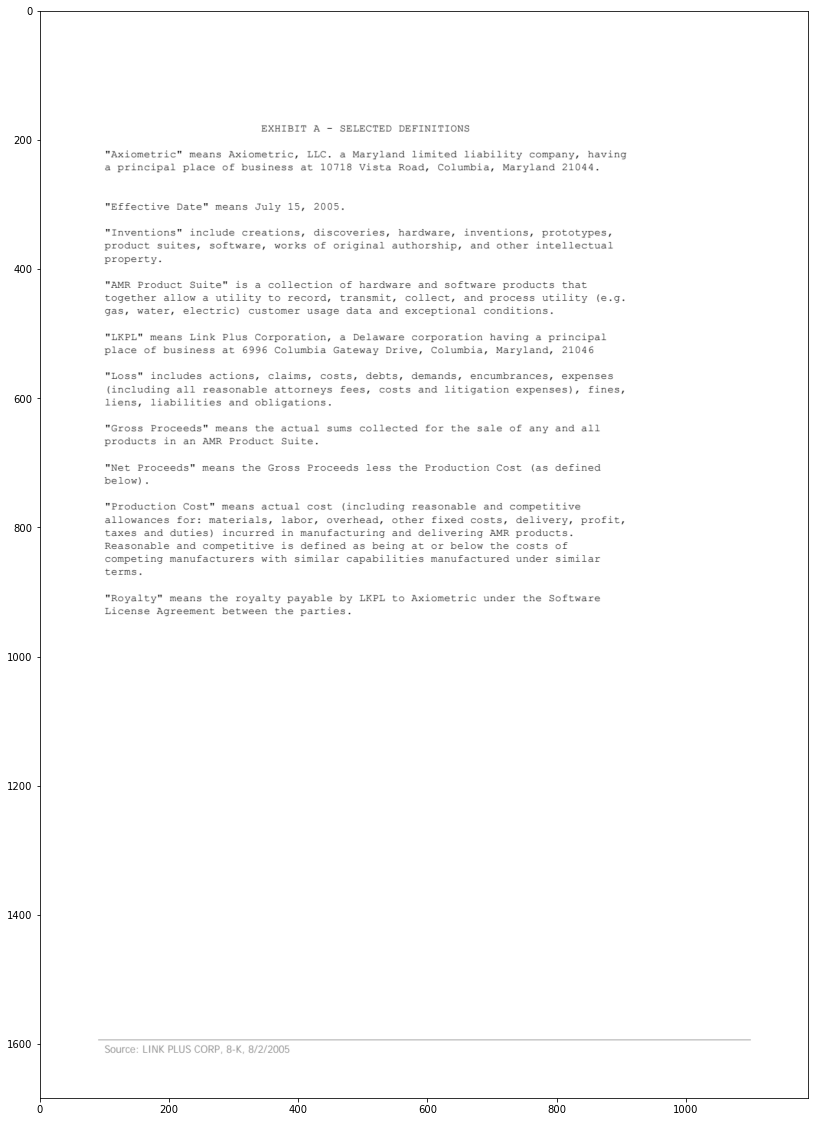

In [52]:
# impage = read_img_as_numpy("SAMPLE_IMAGES_CybergyHoldings_AffiliateAgreement/pg2.jpg")
# CHANGE PAGE NUMBER (for impage and page variables) TO SEE BOUNDING BOXES FOR THE RESPECTIVE PAGE.
# Will cover all pages at once in later commits
impage = full_pdf[6]
page = result.pages[6]
(pageH, pageW) = page.dimensions
# Modified from doctr.utils.vizualization.vizualize_page 
# TODO: Add Apache license 2 to github repo(required)
# Get proper scale and aspect ratio
fig, ax = plt.subplots(figsize = (20, 20))
ax.imshow(impage)

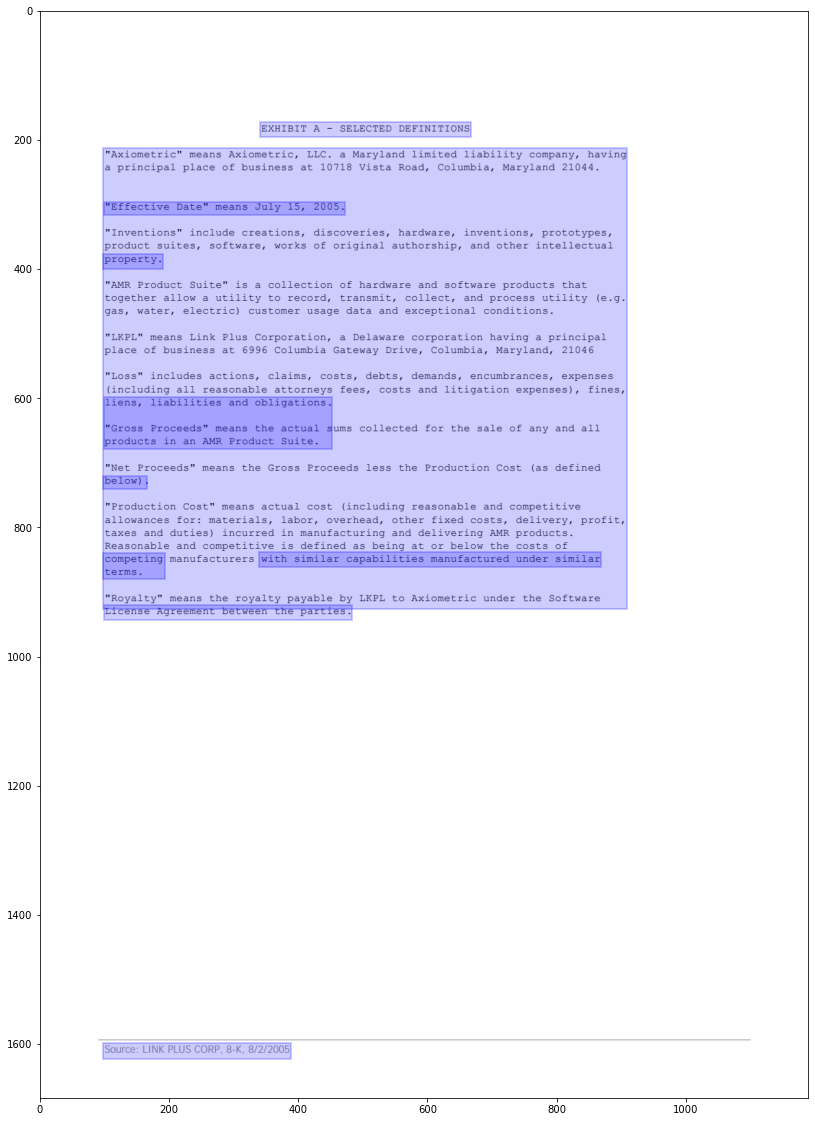

In [53]:
blocks = page.blocks
for block in blocks:
    block_geo = block.geometry
    (xmin, ymin), (xmax, ymax) = block_geo
    xmin, w = xmin * pageW, (xmax - xmin) * pageW
    ymin, h = ymin * pageH, (ymax - ymin) * pageH
    rect_patch = patches.Rectangle(
            (xmin, ymin),
            w,
            h,
            fill=True,
            linewidth=2,
            edgecolor=(0, 0, 1, 0.2),
            facecolor=(0, 0, 1, 0.2),
        )
    ax.add_patch(rect_patch)
fig

In [137]:
print(block_geo)

((0.0986328125, 0.947265625), (0.4189453125, 0.9619140625))


In [1]:

fig

NameError: name 'fig' is not defined

In [118]:
def draw_boxes(
    boxes: np.ndarray,
    image: np.ndarray,
    color: Optional[Tuple[int, int, int]] = None,
    **kwargs
) -> None:
    """Draw an array of relative straight boxes on an image

    Args:
        boxes: array of relative boxes, of shape (*, 4)
        image: np array, float32 or uint8
        color: color to use for bounding box edges
    """
    h, w = image.shape[:2]
    # Convert boxes to absolute coords
    _boxes = deepcopy(boxes)
    _boxes[:, [0, 2]] *= w
    _boxes[:, [1, 3]] *= h
    _boxes = _boxes.astype(np.int32)
    for box in _boxes.tolist():
        xmin, ymin, xmax, ymax = box
        image = cv2.rectangle(
            image,
            (xmin, ymin),
            (xmax, ymax),
            color=color if isinstance(color, tuple) else (0, 0, 255),
            thickness=2
        )
    plt.imshow(image)
    plt.plot(**kwargs)